In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-09-06 13:44:31.259756: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

## Preprocessing

In [3]:
# download DIV2K from TF datasets
# using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

In [4]:
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

2022-09-06 13:44:38.989862: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-06 13:44:39.220360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-09-06 13:44:39.222124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:20:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-09-06 13:44:39.222165: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-09-06 13:44:39.270215: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.

## Flip, crop and resize images

In [5]:
def flip_left_right(lr, hr):
    """Flips images to left or right randomly"""
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(
        rn < 0.5,
        lambda: (lr, hr),
        lambda: (tf.image.flip_left_right(lr), tf.image.flip_left_right(hr))
    )

In [6]:
def random_rotate(lr, hr):
    """rotate image by 90 degrees randomly"""
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr, rn), tf.image.rot90(hr, rn)

In [7]:
def random_crop(lr_img, hr_img, hr_crop_size=96, scale=4):
    """Crop images.
    sub-image for larger training data-set
    low resolution images: 24x24
    high resolution images: 96x96
    """
    lr_crop_size = hr_crop_size // scale  # 96//4=24
    lr_img_shape = tf.shape(lr_img)[:2]  # (height,width)

    lr_width = tf.random.uniform(
        shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32
    )
    lr_height = tf.random.uniform(
        shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32
    )

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[
        lr_height : lr_height + lr_crop_size,
        lr_width : lr_width + lr_crop_size,
    ]  # 24x24
    hr_img_cropped = hr_img[
        hr_height : hr_height + hr_crop_size,
        hr_width : hr_width + hr_crop_size,
    ]  # 96x96

    return lr_img_cropped, hr_img_cropped

## Augmentation

In [23]:
def dataset_object(dataset_cache, batch_size=64, training=True):
    ds = dataset_cache
    ds = ds.map(
        lambda lr, hr: random_crop(lr, hr, scale=4),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)

    # Batching Data
    ds = ds.batch(batch_size)
    if training:
        ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [24]:
train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

## Visualization

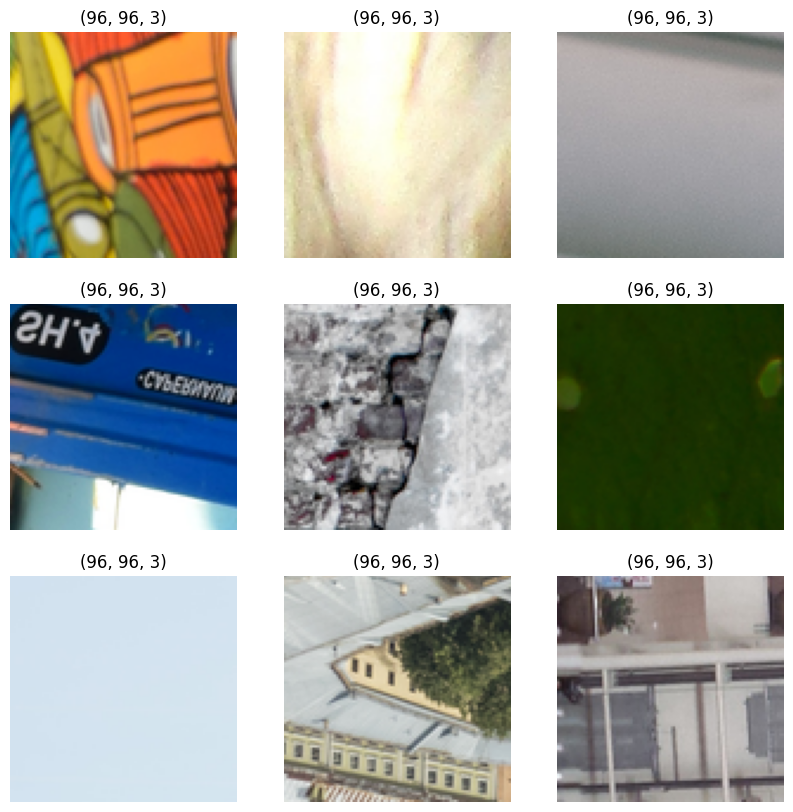

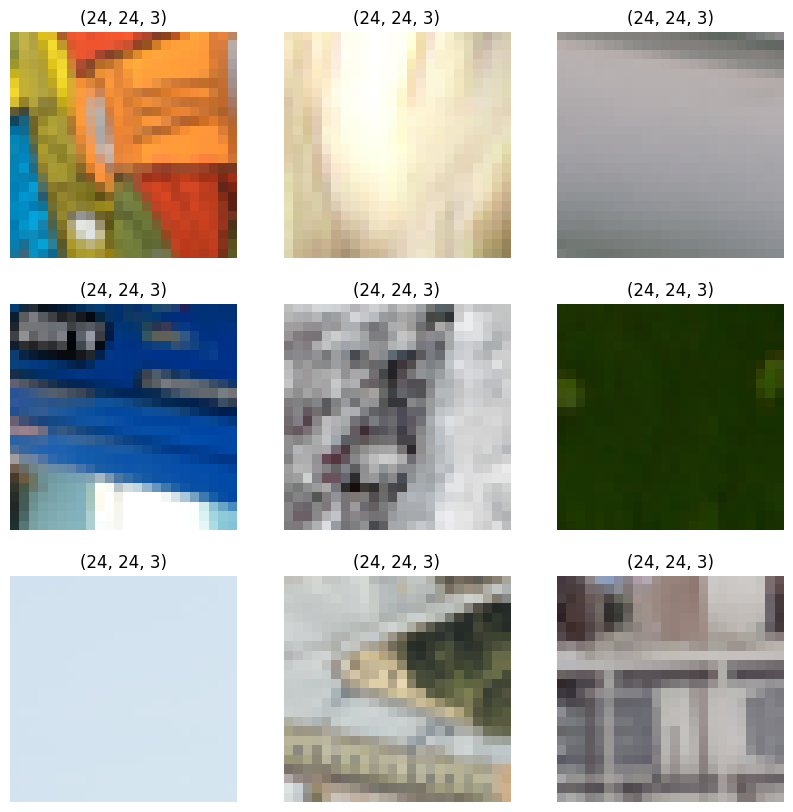

In [25]:
lr, hr = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hr[i].numpy().astype("uint8"))
    plt.title(hr[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lr[i].numpy().astype("uint8"))
    plt.title(lr[i].shape)
    plt.axis("off")

## Metric

In [26]:
def PSNR(sr, hr):
    psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
    return psnr_value

## Build the model

In [27]:
class EDSR(tf.keras.Model):

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # update metric
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img



In [28]:
# defining some blocks
# residual block
def res_block(inputs):
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Add()([inputs, x])
    return x

# up-sampling block
def upsampling_block(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor) # sub-pixel convolution, x2 up-sampling
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [29]:
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = tf.cast(input_layer, tf.float32)/255
    x = x_new = layers.Conv2D(num_filters, 3, padding='same')(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = res_block(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding='same')(x_new)
    x = layers.Add()([x, x_new])
    x = upsampling_block(x)
    x = layers.Conv2D(3, 3, padding='same')(x)

    output_layer = x*255
    return EDSR(input_layer, output_layer)


In [30]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [31]:
model.summary()

Model: "edsr_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_1 (TensorFl [(None, None, None,  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, None, 6 1792        tf_op_layer_RealDiv_1[0][0]      
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, None, 6 36928       conv2d_37[0][0]                  
_____________________________________________________________________________________________

In [32]:
opt = keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    ))
model.compile(optimizer=opt, loss="mae", metrics=[PSNR])
model.fit(train_ds, epochs=100, steps_per_epoch=50, validation_data=val_ds)

Epoch 1/100
50/50 [==============================] - 4s 74ms/step - loss: 49.1805 - PSNR: 12.7819 - val_loss: 23.5022 - val_PSNR: 16.6987
Epoch 2/100
50/50 [==============================] - 3s 63ms/step - loss: 20.9918 - PSNR: 17.7416 - val_loss: 17.9256 - val_PSNR: 19.4076
Epoch 3/100
50/50 [==============================] - 3s 62ms/step - loss: 16.5344 - PSNR: 19.3537 - val_loss: 15.7258 - val_PSNR: 22.5172
Epoch 4/100
50/50 [==============================] - 3s 62ms/step - loss: 14.5959 - PSNR: 20.3050 - val_loss: 13.1947 - val_PSNR: 20.3920
Epoch 5/100
50/50 [==============================] - 3s 61ms/step - loss: 12.9447 - PSNR: 21.4553 - val_loss: 11.7468 - val_PSNR: 26.0239
Epoch 6/100
50/50 [==============================] - 3s 63ms/step - loss: 12.6996 - PSNR: 20.5740 - val_loss: 11.7919 - val_PSNR: 21.5895
Epoch 7/100
50/50 [==============================] - 3s 63ms/step - loss: 11.5065 - PSNR: 22.3963 - val_loss: 12.8192 - val_PSNR: 23.7533
Epoch 8/100
50/50 [===============

(-0.5, 4007.5, 3663.5, -0.5)

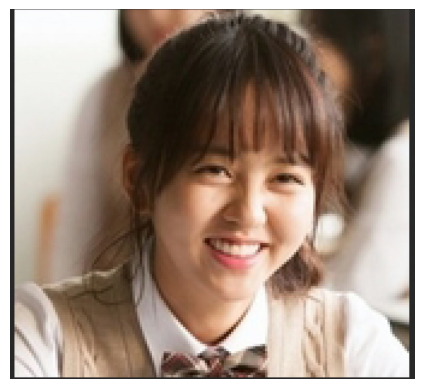

In [33]:
import cv2 

img = cv2.imread('test_imgs/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

SR_img = model.predict(img)

plt.imshow(SR_img.astype("uint8"))
plt.axis("off")

(-0.5, 1001.5, 915.5, -0.5)

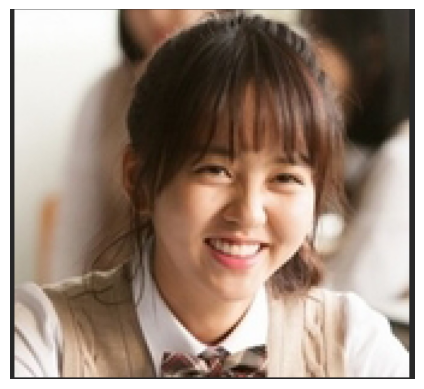

In [22]:
plt.imshow(img.astype("uint8"))
plt.axis("off")